# Load Dependencies

In [2]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List

In [3]:
%run cardiac_ml_tools.py

# Load Data

In [4]:
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR='/home/ssk213/CSE_MSE_RXF131/cradle-members/sdle/ssk213/LLNL/intracardiac_dataset/' 
for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))

Number of file pairs: 16117
Example of file pair:
/home/ssk213/CSE_MSE_RXF131/cradle-members/sdle/ssk213/LLNL/data/intracardiac_dataset/data_hearts_dd_0p2/pECGData_hearts_dd_0p2_volunteer.v10_pattern.0.npy
/home/ssk213/CSE_MSE_RXF131/cradle-members/sdle/ssk213/LLNL/data/intracardiac_dataset/data_hearts_dd_0p2/VmData_hearts_dd_0p2_volunteer.v10_pattern.0.npy


# Graphing 500 ms feature graphs

Case 213 : /home/ssk213/CSE_MSE_RXF131/cradle-members/sdle/ssk213/LLNL/data/intracardiac_dataset/data_hearts_dd_0p2/pECGData_hearts_dd_0p2_volunteer.v1_pattern.18.npy


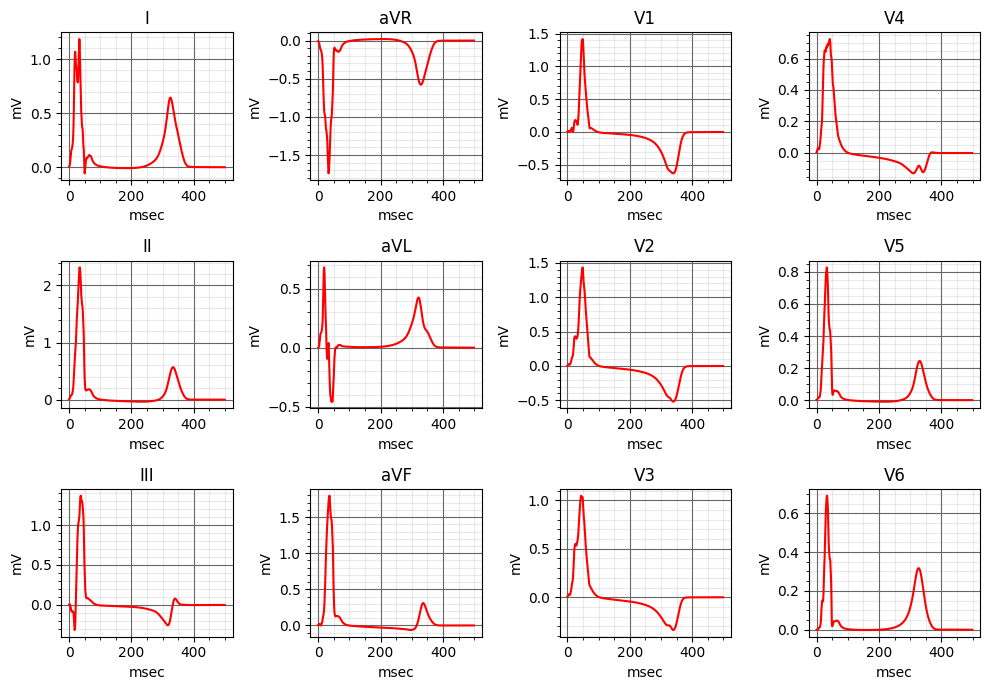

In [5]:
# Example 
case = 213
# ECG plot
row = 3 
column = 4
num_timesteps = 500
plt.figure(figsize=(10, 7))
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
reorder = {1:1,2:5,3:9,4:2,5:6,6:10,7:3,8:7,9:11,10:4,11:8,12:12} # reorder the leads to standard 12-lead ECG display

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

# create a figure with 12 subplots
for i in range(pECGData.shape[1]):
    plt.subplot(row, column, reorder[i + 1])
    plt.plot(pECGData[0:num_timesteps,i],'r')
    plt.title(titles[i])
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('msec')
    plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

# Activation Peak Time Heatmaps

Case 213 : /home/ssk213/CSE_MSE_RXF131/cradle-members/sdle/ssk213/LLNL/data/intracardiac_dataset/data_hearts_dd_0p2/pECGData_hearts_dd_0p2_volunteer.v1_pattern.18.npy


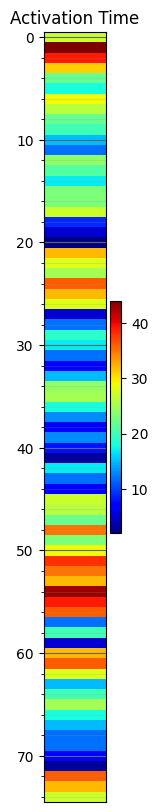

In [6]:
# Example of file pair
ase = 213
plt.figure(figsize=(1, 10))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

ActTime = get_activation_time(VmData)
# plot the Activation Time array
plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('Activation Time')
plt.colorbar()
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
# not xticks
plt.xticks([])
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

# Extracting pECG and Vm Data pairs

In [7]:
import numpy as np

X = []
y = []

def min_max_normalize(X):
    X_min = np.min(X)
    X_max = np.max(X)
    return [(x - X_min) / (X_max - X_min) for x in X]
   
for pair in file_pairs:
    pECGData = np.load(pair[0])
    pECGData = get_standard_leads(pECGData).T
    pECGData = min_max_normalize(pECGData)
    VmData = np.load(pair[1])
    ActTime = get_activation_time(VmData).T
    X.append(pECGData)
    y.append(ActTime)

# Data Train/Test Splitting

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

torch.manual_seed(41)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(np.array(X_train)).float()
X_test = torch.from_numpy(np.array(X_test)).float()
y_train = torch.from_numpy(np.array(y_train)).float()
y_test = torch.from_numpy(np.array(y_test)).float()

print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

examples = iter(train_loader)
samples, labels = next(examples)
print(f"One Batch Size: {samples.shape, labels.shape}")

X_train shape: torch.Size([12893, 12, 500])
X_test shape: torch.Size([3224, 12, 500])
y_train shape: torch.Size([12893, 1, 75])
y_test shape: torch.Size([3224, 1, 75])
One Batch Size: (torch.Size([32, 12, 500]), torch.Size([32, 1, 75]))


# Model

Using device: cuda
ConvNet(
  (conv1): Conv1d(12, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=75, bias=True)
)
Epoch [1/50], Step [100/403], Loss: 1400.4633
Epoch [1/50], Step [200/403], Loss: 802.3245
Epoch [1/50], Step [300/403], Loss: 733.1082
Epoch [1/50], Step [400/403], Loss: 782.0513
Epoch [2/50], Step [100/403], Loss: 673.1005
Epoch [2/50], Step [200/403], Loss: 540.4896
Epoch [2/50], Step [300/403], Loss: 573.4865
Epoch [2/50], Step [400/403], Loss: 687.1402
Epoch [3/50], Step [100/403], Loss: 584.8374
Epoch [3/50], Step [200/403], Loss: 538.4134
Epoch [3/50], Step [300/403], Loss: 695.4733
Ep

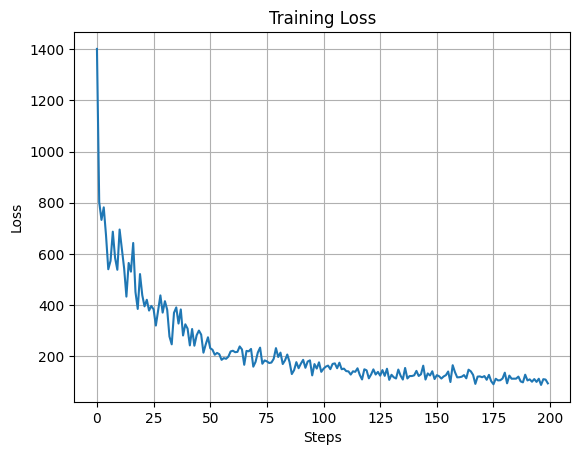

In [9]:
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class ConvNet(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(input_shape[0], 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(128, 128, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(16000, 128)

        self.output_shape = output_shape
        self.fc2 = nn.Linear(128, np.prod(output_shape))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x.view(-1, *self.output_shape)
        
    
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = (y_test.shape[1], y_train.shape[2])

# Initialize the model
model = ConvNet(input_shape, output_shape).to(device)
print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

epochs = 50
n_total_steps = len(train_loader)
losses = []

for epoch in range(epochs):
    for i, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)
        
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            losses.append(loss.item())

print("Finished Training")

# Plot the training loss
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Calculating Accuracy

In [10]:
with torch.no_grad():
    n_samples = 0
    total_loss = 0.0
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        n_samples += labels.size(0)
        total_loss += loss.item() * labels.size(0)

    avg_loss = total_loss / n_samples
    print(f"Number of samples: {n_samples}")
    print(f"Average Loss: {avg_loss:.4f}")

Number of samples: 3224
Average Loss: 113.8548


# Comparing Model and Simulation Heatmaps

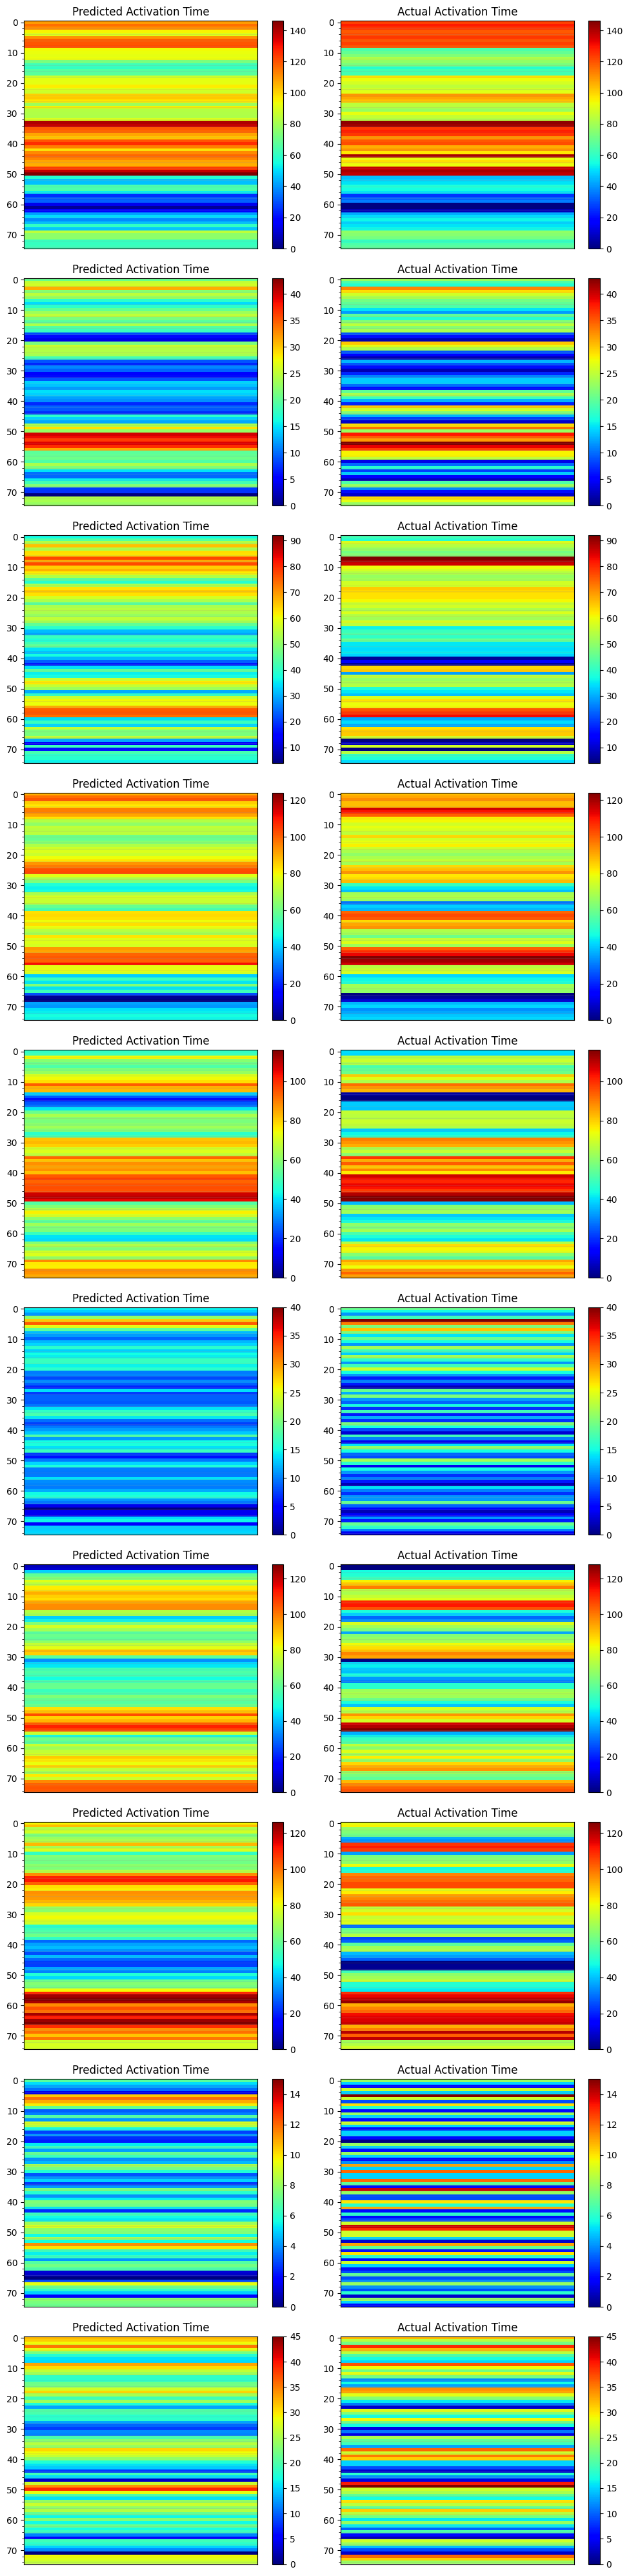

In [11]:
with torch.no_grad():
    model = model.cpu()
    X_test = X_test.cpu()
    y_pred = model(X_test)

y_pred = y_pred.cpu().detach().numpy()
y_test = y_test.cpu().detach().numpy()

# plot the activation time heatmap for first 10 predicted
num = 10
fig, axs = plt.subplots(num, 2, figsize=(10, num*4))

for i in range(num):

    pred_data = y_pred[i+1000].reshape(-1, 1)
    test_data = y_test[i+1000].reshape(-1, 1)

    v_min = min(np.min(pred_data), np.min(test_data))
    v_max = max(np.max(pred_data), np.max(test_data))

    # Predicted activation times
    ax = axs[i, 0]
    im = ax.imshow(pred_data, cmap='jet', interpolation='nearest', aspect='auto', vmin=v_min, vmax=v_max)
    ax.set_title('Predicted Activation Time')
    fig.colorbar(im, ax=ax)
    ax.minorticks_on()
    ax.set_xticks([])
    ax.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    # Actual activation times
    ax = axs[i, 1]
    im = ax.imshow(test_data, cmap='jet', interpolation='nearest', aspect='auto', vmin=v_min, vmax=v_max)
    ax.set_title('Actual Activation Time')
    fig.colorbar(im, ax=ax)
    ax.minorticks_on()
    ax.set_xticks([])
    ax.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.tight_layout()
plt.show()

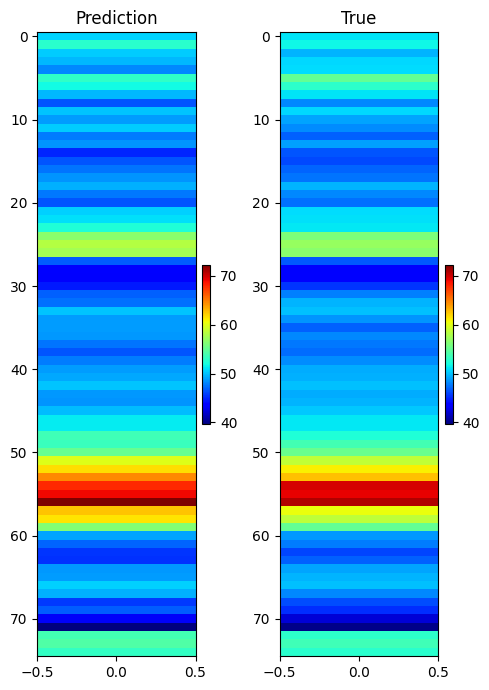

In [29]:
y_pred_mean = np.mean(y_pred, axis=0)
y_test_mean = np.mean(y_test, axis=0)

v_min = np.min([y_pred_mean, y_test_mean])
v_max = np.max([y_pred_mean, y_test_mean])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 7))

# Plot for Predicted Activation Times
im1 = ax1.imshow(y_pred_mean.reshape(1, -1).T, cmap='jet', interpolation='nearest', aspect='auto', vmin=v_min, vmax=v_max)
ax1.set_title('Prediction')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)  # Adjust width here

# Plot for True Activation Time
im2 = ax2.imshow(y_test_mean.reshape(1, -1).T, cmap='jet', interpolation='nearest', aspect='auto', vmin=v_min, vmax=v_max)
ax2.set_title('True')
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)  # Adjust width here

# Adjust layout
plt.tight_layout()

# Increase space between subplots if needed
fig.subplots_adjust(wspace=0.4)  

plt.show()

# Some Accuracy Metrics

In [32]:
differences = y_pred_mean - y_test_mean
print("Mean differences for each of the 75 points: ")
print(differences)

percentage_diff = np.mean(100 * (differences / y_test_mean))

correlation = np.corrcoef(y_pred_mean, y_test_mean)[0, 1]

print(f"Correlation coefficient: {correlation}")
print(f"Mean absolute difference: {np.mean(np.abs(differences))}")
print(f"Mean percentage difference: {np.mean(np.abs(percentage_diff))}%")

Mean differences for each of the 75 points: 
[[-0.49700165  1.0029335   0.75242996 -1.0832329  -2.6465416  -2.0926437
  -1.0464478  -1.5052872  -1.6309929  -0.5828743  -0.2172432   1.9578972
   0.8304024  -0.40522385 -1.5362625   0.4092331   0.54961014  1.0380249
  -0.10744095 -0.5726929  -0.80923843 -0.29984665  0.07180786  1.1269493
   0.5416527   1.1328468   1.1179085   0.13105011 -0.24186707 -0.37259674
  -0.9298706  -0.98433685 -2.188324    0.18947983  0.2898445   1.8326187
   0.5358124  -0.14570236 -0.78341675 -0.4636383  -0.44947433 -0.28059387
   0.09690094 -0.6768646  -1.0932045  -0.35032272  0.11030197  0.12742233
   1.3532028  -0.38189316 -0.1667099   1.1661835   0.6618004   1.9338875
  -1.8521271  -0.2793274   1.4621353   2.1714592   2.8981972   1.2946777
   0.38922882 -0.76807785 -0.5676575  -1.6118965  -0.37192535 -0.7904587
   0.49523926  1.2300491  -0.6889839   1.614048    1.0565186  -0.26120377
   0.8806267   0.6667938   0.2872429 ]]
Correlation coefficient: 0.98423849